# Etape 1: importer les librairies et lire les datasets

In [17]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from lightgbm import LGBMClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_val_score

test = pd.read_csv('input\\test.csv')
train = pd.read_csv('input\\train.csv')
print('Dimensions train:', train.shape)
print('Dimensions test:', test.shape)

train.columns

Dimensions train: (700000, 26)
Dimensions test: (300000, 25)


Index(['id', 'age', 'alcohol_consumption_per_week',
       'physical_activity_minutes_per_week', 'diet_score',
       'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi',
       'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate',
       'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol',
       'triglycerides', 'gender', 'ethnicity', 'education_level',
       'income_level', 'smoking_status', 'employment_status',
       'family_history_diabetes', 'hypertension_history',
       'cardiovascular_history', 'diagnosed_diabetes'],
      dtype='object')

# Etape 2: classer les features par features numériques et catégoriques

In [18]:
target = 'diagnosed_diabetes'
features = [col for col in train.columns if col not in [target, 'id']]
numerical_features = train[features].select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = train[features].select_dtypes(include=['object', 'category']).columns.tolist()
print('Features:', features)
print('Numerical Features:', numerical_features)
print('Categorical Features:', categorical_features)

Features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Numerical Features: ['age', 'alcohol_consumption_per_week', 'physical_activity_minutes_per_week', 'diet_score', 'sleep_hours_per_day', 'screen_time_hours_per_day', 'bmi', 'waist_to_hip_ratio', 'systolic_bp', 'diastolic_bp', 'heart_rate', 'cholesterol_total', 'hdl_cholesterol', 'ldl_cholesterol', 'triglycerides', 'family_history_diabetes', 'hypertension_history', 'cardiovascular_history']
Categorical Features: ['gender', 'ethnicity', 'education_level', 'income_level', 'smoking_status', 'employment_status']


# Etape 3: détection des valeurs manquantes

In [19]:
print('Valeurs nulles:', train[categorical_features].isnull().sum().sum(),'\n')
print(train[categorical_features].nunique(),'\n')

Valeurs nulles: 0 

gender               3
ethnicity            5
education_level      4
income_level         5
smoking_status       3
employment_status    4
dtype: int64 



In [20]:

print('Valeurs nulles:', test[numerical_features].isnull().sum().sum(),'\n')
print(test[numerical_features].nunique(),'\n')

Valeurs nulles: 0 

age                                    71
alcohol_consumption_per_week            9
physical_activity_minutes_per_week    544
diet_score                             99
sleep_hours_per_day                    68
screen_time_hours_per_day             147
bmi                                   230
waist_to_hip_ratio                     37
systolic_bp                            77
diastolic_bp                           54
heart_rate                             60
cholesterol_total                     165
hdl_cholesterol                        68
ldl_cholesterol                       165
triglycerides                         237
family_history_diabetes                 2
hypertension_history                    2
cardiovascular_history                  2
dtype: int64 



# Etape 4: Visualisation de la target et matrice de corrélation

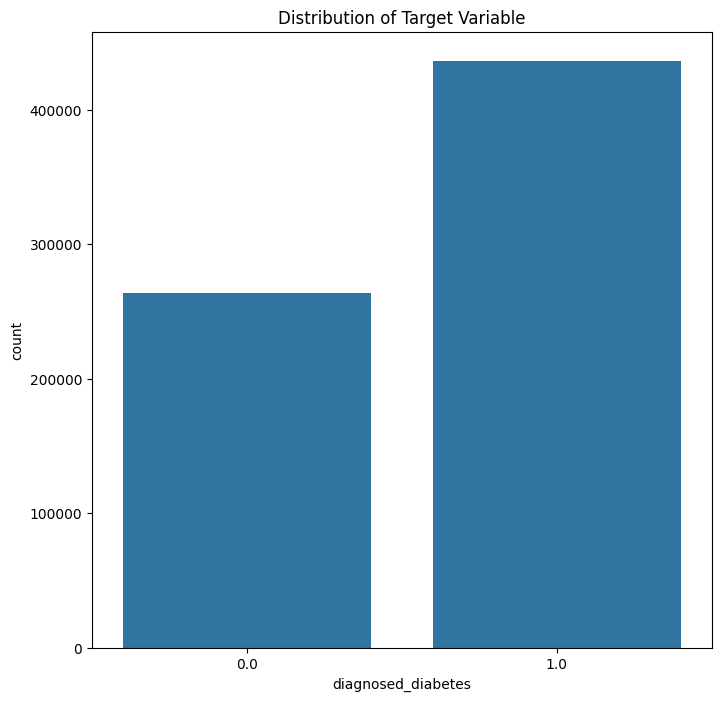

In [21]:
fig, ax = plt.subplots(1,1,figsize=(8,8))
sns.countplot(data=train, x=target, ax=ax)
ax.set_title('Distribution of Target Variable')
plt.show()

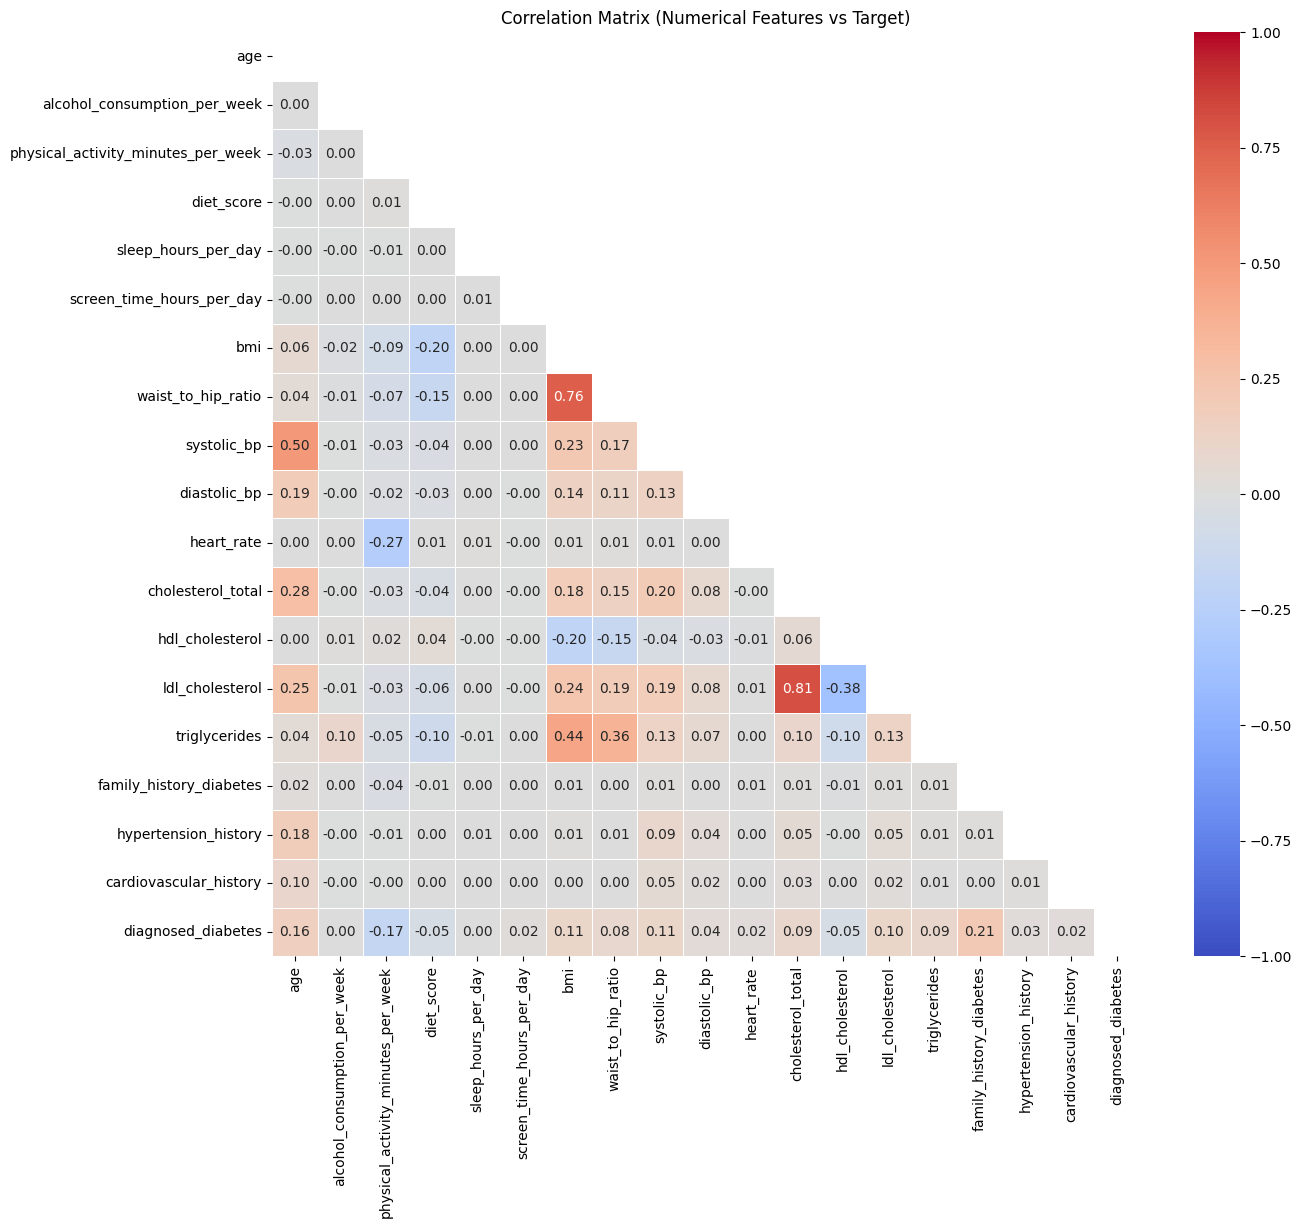

In [22]:
corr_features = numerical_features + [target]
corr_matrix = train[corr_features].corr()

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(14, 12))
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt=".2f", 
            cmap='coolwarm', vmin=-1, vmax=1, linewidths=0.5)
plt.title('Correlation Matrix (Numerical Features vs Target)')
plt.show()

# Etape 5: Feature engineering (je ne le fais pas pour l'instant)

In [23]:
# Feature Engineering
def add_features(df):
    df['feature_mean'] = df[numerical_features].mean(axis=1)
    df['feature_std'] = df[numerical_features].std(axis=1)
    df['feature_max'] = df[numerical_features].max(axis=1)
    df['feature_min'] = df[numerical_features].min(axis=1)
    return df

# # appliquer sur train et test
# train = add_features(train)
# test = add_features(test)

# Etape 6: modèle et entraînement

In [24]:
# Supprimer la colonne id
X = train.drop(['id', target], axis=1)
y = train[target]

# Garder les mêmes colonnes dans le test
test_ids = test['id']
X_test = test.drop('id', axis=1)

In [25]:
# Fusion pour avoir les mêmes catégories dans train et test
full_data = pd.concat([X, X_test], axis=0)

# Encoder les colonnes catégorielles
for col in full_data.select_dtypes('object').columns:
    full_data[col] = LabelEncoder().fit_transform(full_data[col].astype(str))

# Séparer à nouveau train/test
X = full_data.iloc[:len(train), :]
X_test = full_data.iloc[len(train):, :]

In [26]:
# Split train/validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
# Modèle LGBM --> AUC = 0.7269
model = LGBMClassifier(
    n_estimators=1500,
    learning_rate=0.02,
    max_depth=8,
    num_leaves=64,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.2,
    reg_lambda=0.2,
    random_state=42
)
model.fit(X_train, y_train)

[LightGBM] [Info] Number of positive: 348936, number of negative: 211064
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.031349 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1645
[LightGBM] [Info] Number of data points in the train set: 560000, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.623100 -> initscore=0.502727
[LightGBM] [Info] Start training from score 0.502727
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best ga

,boosting_type,'gbdt'
,num_leaves,64
,max_depth,8
,learning_rate,0.02
,n_estimators,1500
,subsample_for_bin,200000
,objective,None
,class_weight,None
,min_split_gain,0.0
,min_child_weight,0.001
,min_child_samples,20


# Etape 7: Résultats

In [28]:
# Evaluation locale
y_pred = model.predict_proba(X_val)[:, 1]
auc = roc_auc_score(y_val, y_pred)
print("Score AUC local:" + str(round(auc,4)))

Score AUC local:0.7269


In [29]:
# Prédictions sur le test
test_pred = model.predict_proba(X_test)[:, 1]

In [30]:
# Fichier de soumission
submission = pd.DataFrame({
    "id": test_ids,
    "diagnosed_diabetes": test_pred
})

submission.to_csv("output\\submission.csv", index=False)
print("Fichier 'submission.csv' créé avec succès !")


Fichier 'submission.csv' créé avec succès !
